In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cat = Table.read('CUT_CLAUDS_HSC_VISTA_Ks23.3_PHYSPARAM_TM.fits')
cat_gal = cat[cat['CLASS'] == 0]

## Total Satellite Mass Evolution

In [54]:
total_mass_sat_log = open('total_mass_sat')
z = []
mass_sat= []
mass_sat_sf = []
mass_sat_q = []
std_mass_sat = []
std_mass_sat_sf = []
std_mass_sat_q = []

for line in total_mass_sat_log.readlines():
    z.append(eval(line.split()[0]))
    mass_sat.append(eval(line.split()[1]))
    mass_sat_sf.append(eval(line.split()[2]))
    mass_sat_q.append(eval(line.split()[3]))
    std_mass_sat.append(eval(line.split()[4]))
    std_mass_sat_sf.append(eval(line.split()[5]))
    std_mass_sat_q.append(eval(line.split()[6]))

z = np.array(z)
mass_sat = np.array(mass_sat)
mass_sat_sf = np.array(mass_sat_sf)
mass_sat_q = np.array(mass_sat_q)
std_mass_sat = np.array(std_mass_sat)
std_mass_sat_sf = np.array(std_mass_sat_sf)
std_mass_sat_q = np.array(std_mass_sat_q)

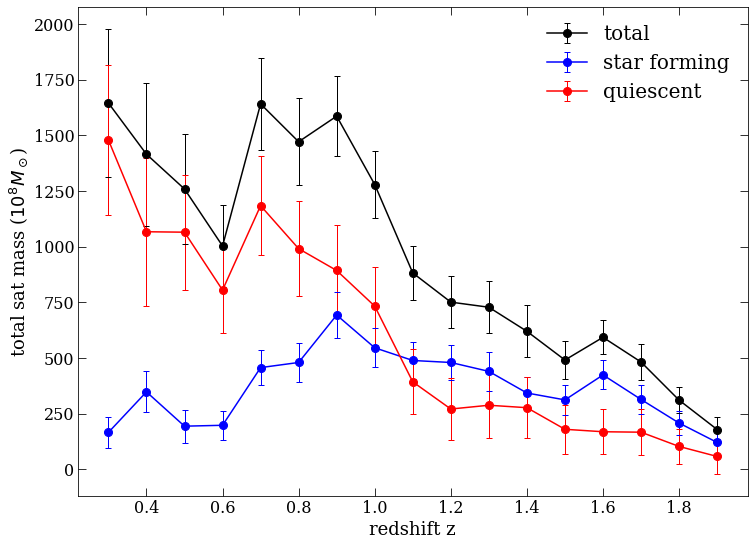

In [55]:
fig = plt.figure(figsize=(12,9))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=16), plt.rc('ytick', labelsize=16)

plt.errorbar(z,mass_sat, yerr=std_mass_sat, fmt='.-k',markersize=16, capsize=3, elinewidth=1,label='total')
plt.errorbar(z,mass_sat_sf, yerr=std_mass_sat_sf, fmt='.-b',markersize=16, capsize=3, elinewidth=1,label='star forming')
plt.errorbar(z,mass_sat_q, yerr=std_mass_sat_q, fmt='.-r',markersize=16, capsize=3, elinewidth=1, label='quiescent')

plt.xlabel('redshift z', fontsize=18)
plt.ylabel(r'total sat mass ($10^8 M_\odot$)', fontsize=18)
plt.tick_params(axis='both',direction='in',which='major',length=8,top='on',right='on')
plt.tick_params(axis='both',direction='in',which='minor',length=4,top='on',right='on')
plt.legend(fontsize=20,frameon=False)
plt.savefig('total_sat_mass_z.png')
plt.show()

In [31]:
cat_high_z = cat_gal[cat_gal['ZPHOT']>5]
np.min(abs(cat_high_z['MASS_BEST']))

4.54047

## Massive Gals Evolution

In [24]:
cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]

massive_mass_z = []
std_massive_mass_z = []
for z in np.arange(0.3,2.0,0.1):
    cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
    massive_mass_z.append(np.mean(cat_massive_z_slice['MASS_BEST']))
    std_massive_mass_z.append(np.std(cat_massive_z_slice['MASS_BEST']))

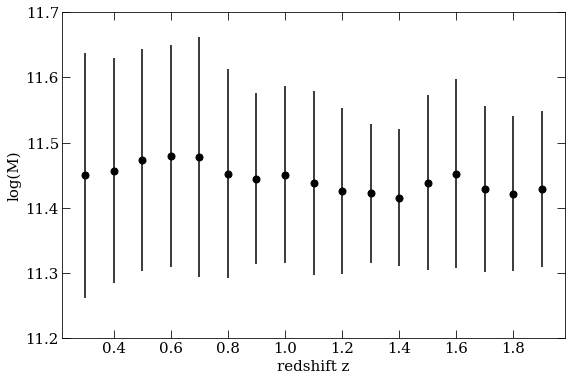

In [25]:
fig = plt.figure(figsize=(9,6))

z = np.arange(0.3,2.0,0.1)
plt.errorbar(z,massive_mass_z, yerr=std_massive_mass_z, fmt='.k',markersize=14)

plt.xlabel('redshift z', fontsize=15)
plt.ylabel('log(M)', fontsize=15)
plt.ylim([11.2,11.7])
plt.tick_params(axis='both',direction='in',which='major',length=8,top='on',right='on')
plt.tick_params(axis='both',direction='in',which='minor',length=4,top='on',right='on')
plt.savefig('massive_gal_mass_z.png')
plt.show()

## Uniformity of Blank Pointings

In [4]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
from random import random
import astropy.units as u
from astropy.cosmology import Planck15, WMAP9

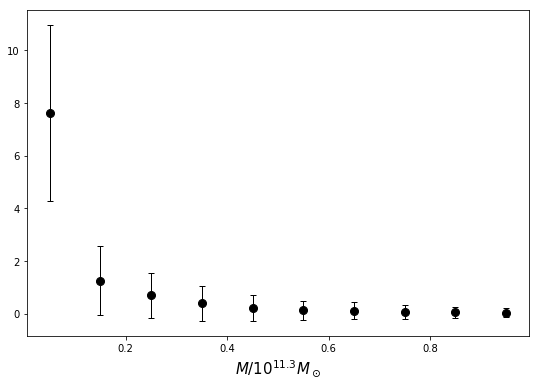

In [5]:
z = 1.1
dis = WMAP9.angular_diameter_distance(z).value

cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]
cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT'] - z) < 0.1]

cat_massive_z_slice['RA'].unit = u.deg
cat_massive_z_slice['DEC'].unit = u.deg
coord_massive_gal = SkyCoord.guess_from_table(cat_massive_z_slice)

counts_var = []
for i in range(0,1000):
    rand_id = int(random()*len(cat_all_z_slice))
    ra_rand = cat_all_z_slice[rand_id]['RA']
    dec_rand = cat_all_z_slice[rand_id]['DEC']
    idx, sep2d, dist3d = match_coordinates_sky(SkyCoord(ra_rand, dec_rand, unit="deg"), coord_massive_gal, nthneighbor=1)
    
    if sep2d.degree > 1.5/dis/np.pi*180:
        cat_neighbors_rand = cat_all_z_slice[(cat_all_z_slice['RA'] - ra_rand) ** 2 + (cat_all_z_slice['DEC'] - dec_rand) ** 2 < (0.5 / dis / np.pi * 180) ** 2]
        mass_neighbors_rand = cat_neighbors_rand['MASS_BEST']
        count_gal_rand, edges_rand = np.histogram(10**(mass_neighbors_rand - 11.3) , np.arange(0,1.01,0.1))
        
        counts_var.append(count_gal_rand)

counts_var_all = np.vstack(counts_var)
std = np.std(counts_var_all, axis=0)
mean = np.mean(counts_var_all, axis=0)

fig = plt.figure(figsize=(9,6))
plt.errorbar(edges_rand[0:-1]+0.05,mean,yerr=std, fmt='.k', markersize=16, capsize=3, elinewidth=1)
# plt.ylim([0,15])
plt.xlabel(r'$M/10^{11.3}M_\odot$', fontsize=15)
plt.savefig('background.png')
plt.show()

In [10]:
from astropy.stats import bootstrap

(1888.4099220037183, 1461.9352568534819)
(1903.5569299350789, 259.14018639192943)


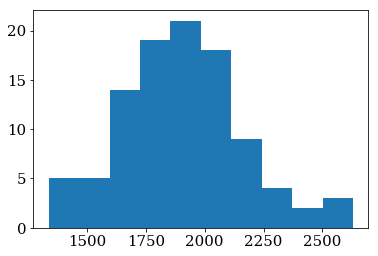

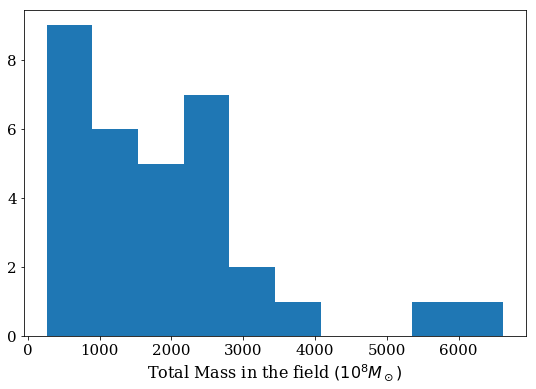

In [23]:
z = 1.1
dis = Planck15.angular_diameter_distance(z).value

cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]
cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT'] - z) < 0.1]

cat_massive_z_slice['RA'].unit = u.deg
cat_massive_z_slice['DEC'].unit = u.deg
coord_massive_gal = SkyCoord.guess_from_table(cat_massive_z_slice)

total_mass_neighbrs_rand = []
for i in range(0,200):
    rand_id = int(random()*len(cat_all_z_slice))
    ra_rand = cat_all_z_slice[rand_id]['RA']
    dec_rand = cat_all_z_slice[rand_id]['DEC']
    idx, sep2d, dist3d = match_coordinates_sky(SkyCoord(ra_rand, dec_rand, unit="deg"), coord_massive_gal, nthneighbor=1)
    
    if sep2d.degree > 3.0/dis/np.pi*180:
        cat_neighbors_rand = cat_all_z_slice[(cat_all_z_slice['RA'] - ra_rand) ** 2 + (cat_all_z_slice['DEC'] - dec_rand) ** 2 < (0.5 / dis / np.pi * 180) ** 2]
        if np.sum(10**(cat_neighbors_rand[cat_neighbors_rand['MASS_BEST']>10]['MASS_BEST']-8))==0: continue
        total_mass_neighbrs_rand.append(np.sum(10**(cat_neighbors_rand[cat_neighbors_rand['MASS_BEST']>10]['MASS_BEST']-8)))

total_mass_neighbrs_rand = np.array(total_mass_neighbrs_rand)
print(np.mean(total_mass_neighbrs_rand), np.std(total_mass_neighbrs_rand))
bootresult = bootstrap(total_mass_neighbrs_rand,100,bootfunc=np.mean)
plt.hist(bootresult)
print(np.mean(bootresult), np.std(bootresult))

fig = plt.figure(figsize=(9,6))
plt.hist(total_mass_neighbrs_rand)
plt.xlabel(r'Total Mass in the field $(10^8 M_\odot)$',fontsize=16)
plt.savefig('background_mass.png')
plt.show()

## massive gal distribution

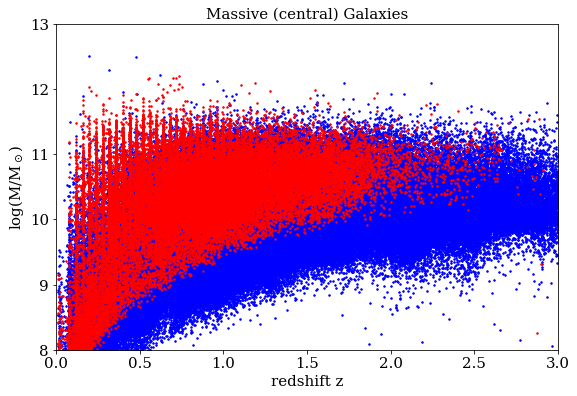

In [261]:
fig = plt.figure(figsize=(9,6))
plt.plot(cat_gal[cat_gal['SSFR_BEST']>-11]['ZPHOT'],cat_gal[cat_gal['SSFR_BEST']>-11]['MASS_BEST'],'.b',markersize=3)
plt.plot(cat_gal[cat_gal['SSFR_BEST']<-11]['ZPHOT'],cat_gal[cat_gal['SSFR_BEST']<-11]['MASS_BEST'],'.r',markersize=3)
plt.title('Massive (central) Galaxies', fontsize=15)
plt.ylim([8,13])
plt.xlim([0,3])
plt.xlabel('redshift z', fontsize=15)
plt.ylabel(r'log(M/M$_\odot$)', fontsize=15)
plt.show()

## angle separation

In [220]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [221]:
def spherical_separation(ra1, dec1, ra2, dec2):
    '''ra1,dec1 can be array or scalar. ra2,dec2 are scalars'''
    ra1 = ra1/180.*np.pi
    ra2 = ra2/180.*np.pi
    dec1 = dec1/180.*np.pi
    dec2 = dec2/180.*np.pi
    return np.arccos(np.sin(dec1)*np.sin(dec2)+np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2))/np.pi*180

def separation(ra1, dec1, ra2, dec2):
    '''ra1,dec1 can be array or scalar. ra2,dec2 are scalars'''
    return np.sqrt((ra1-ra2)**2+(dec1-dec2)**2)

In [241]:
ra1 = cat_gal['RA']
dec1 = cat_gal['DEC']
ra2 = cat_gal[122]['RA']
dec2 = cat_gal[122]['DEC']
# print(ra1, dec1, ra2, dec2)
# print(spherical_separation(ra1, dec1, ra2, dec2))
# print(separation(ra1, dec1, ra2, dec2))

c1 = SkyCoord(ra1*u.deg,dec1*u.deg)
c2 = SkyCoord(ra2*u.deg,dec2*u.deg)

## physical search radius

In [19]:
from astropy.cosmology import Planck15, WMAP9

In [20]:
z=0.3
dis = WMAP9.angular_diameter_distance(z).value
print(dis)
0.5/dis/np.pi*180

930.498307159


0.030787686056097347

## Volumne Density Matching
for massive central gals,
constant surface density == total number counts proportional to dis**2

In [120]:
for z in np.arange(0.3, 2.0, 0.1):
    dis_l = WMAP9.comoving_distance(z-0.1).value
    dis_h = WMAP9.comoving_distance(z+0.1).value
    
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    density = 0.00003 # Mpc^-3
    num = int(density*survey_v)  # surface densisty propto dis**2
    
    cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_gal_z_slice.sort('MASS_BEST')
    cat_gal_z_slice.reverse()
    
    print(cat_gal_z_slice[num]['MASS_BEST'],len(cat_gal_z_slice[:num]))

(11.4541, 40)
(11.4595, 64)
(11.4779, 89)
(11.4472, 115)
(11.4007, 140)
(11.3679, 164)
(11.3685, 186)
(11.3607, 205)
(11.3116, 223)
(11.3039, 239)
(11.2925, 252)
(11.2817, 264)
(11.2467, 274)
(11.2058, 283)
(11.1989, 290)
(11.1964, 296)
(11.1869, 300)
